# Problem/need: Predicting whether a non-NYPD subject involved in a force incident will be injured or not

recall = tp/ap = tp/(tp+fn)

Since false negatives (predicting that use of force doesn't result in a subject being injured when it actually does) are more costly, I'm going to weight recall more heavily than precision by using F2 as my evaluation metric.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import statistics
import math
import os

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score

import imblearn.over_sampling

In [2]:
os.getcwd()

'/Users/chloebergsma-safar/Desktop/Metis/NBM_Classification_Project/Metis-Classification'

In [3]:
os.chdir('/Users/chloebergsma-safar/Desktop/Metis/NBM_Classification_Project')

# Read in NYPD Use of Force datasets

## incidents

In [4]:
incidents = pd.read_csv('NYPD_Use_of_Force_Incidents.csv')

In [5]:
incidents.shape

(13527, 7)

In [6]:
incidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13527 entries, 0 to 13526
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   TRI Incident Number  13527 non-null  int64 
 1   ForceType            13527 non-null  object
 2   Occurrence Date      13527 non-null  object
 3   Incident Pct         13527 non-null  int64 
 4   Patrol Borough       13527 non-null  object
 5   YearMonthShort       13527 non-null  object
 6   BasisForEncounter    13527 non-null  object
dtypes: int64(2), object(5)
memory usage: 739.9+ KB


## members of service

In [7]:
members = pd.read_csv('NYPD_Use_of_Force__Members_of_Service.csv')

In [8]:
members.shape

(31257, 8)

In [9]:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31257 entries, 0 to 31256
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   TRI Incident Number  31257 non-null  int64 
 1   ForceType            31257 non-null  object
 2   InjuryLevel          31257 non-null  object
 3   Member Injured       31257 non-null  object
 4   Rank Grouped         31257 non-null  object
 5   Assignment           31257 non-null  object
 6   Member Gender        31257 non-null  object
 7   Race                 31257 non-null  object
dtypes: int64(1), object(7)
memory usage: 1.9+ MB


## subjects

In [10]:
subjects = pd.read_csv('NYPD_Use_of_Force__Subjects.csv')

In [11]:
subjects.shape

(13283, 8)

In [12]:
subjects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13283 entries, 0 to 13282
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TRI Incident Number   13283 non-null  int64  
 1   Subject Injury Level  13283 non-null  object 
 2   Subject Injured       13283 non-null  object 
 3   Age                   12741 non-null  float64
 4   Subject Race          13283 non-null  object 
 5   Subject Gender        13283 non-null  object 
 6   Force Against MOS     13283 non-null  object 
 7   Subject Used Force    13283 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 830.3+ KB


# Brielfy analyze individual datasets

## incidents

In [13]:
incidents.columns

Index(['TRI Incident Number', 'ForceType', 'Occurrence Date', 'Incident Pct',
       'Patrol Borough', 'YearMonthShort', 'BasisForEncounter'],
      dtype='object')

In [14]:
incidents['Occurrence Date'].value_counts()

06/01/2020    82
01/01/2020    69
06/02/2020    64
05/29/2020    63
05/31/2020    51
              ..
07/17/2020     4
03/28/2021     4
07/18/2020     4
07/16/2020     2
07/06/2020     1
Name: Occurrence Date, Length: 731, dtype: int64

In [15]:
incidents['ForceType'].value_counts()

Physical Force              10172
Electrical Weapon            2855
OC Spray                      259
Impact Weapon                 142
Firearm                        88
Restraining Mesh Blanket        8
Police Canine                   3
Name: ForceType, dtype: int64

In [16]:
incidents['BasisForEncounter'].value_counts()

CRIME/VIOLATION IN PROGRESS              5279
PERSON IN CRISIS                         3235
OTHER                                    1273
PRISONER                                 1092
CROWD CONTROL                             526
VTL INFRACTION                            441
WANTED SUSPECT (E.G. WARRANT, I CARD)     437
PAST CRIME/VIOLATION                      402
SUSPICIOUS ACTIVITY                       226
DETECTIVE INVESTIGATION                   140
TRANSIT EJECTION                          104
NON-CRIME CALLS FOR SERVICE                95
ORDER OF PROTECTION                        95
IN CUSTODY INJURY                          71
HOME VISIT                                 38
AMBUSH OF MEMBER                           23
SEARCH WARRANT                             23
ANIMAL CONDITION                           14
HOSTAGE/BARRICADED                         13
Name: BasisForEncounter, dtype: int64

## members

In [17]:
members.columns

Index(['TRI Incident Number', 'ForceType', 'InjuryLevel', 'Member Injured',
       'Rank Grouped', 'Assignment', 'Member Gender', 'Race'],
      dtype='object')

In [18]:
members['InjuryLevel'].value_counts()

No Injury                      25794
Physical Injury                 5062
Substantial Physical Injury      261
Serious Physical Injury          140
Name: InjuryLevel, dtype: int64

In [19]:
members['Rank Grouped'].value_counts()

Police Officer      26512
Sergeant             2353
Detective            1251
Lieutenant            718
Other                 290
Captain                71
Deputy Inspector       26
Inspector              15
Chief                  13
RECODE                  8
Name: Rank Grouped, dtype: int64

In [20]:
members['Assignment'].value_counts()

SECTOR/RESPONSE AUTO    19003
OTHER                    6168
FIXED POST               1919
ANTI-CRIME               1897
NCO                      1122
INVESTIGATION            1055
OFF DUTY                   71
SCOOTER                    22
Name: Assignment, dtype: int64

In [21]:
members['Member Gender'].value_counts()

MALE      27817
FEMALE     3440
Name: Member Gender, dtype: int64

In [22]:
members['Race'].value_counts()

WHITE          14767
HISPANIC       10001
BLACK           3775
ASIAN           2673
AMER INDIAN       25
OTH/UNK           16
Name: Race, dtype: int64

## subjects

In [23]:
subjects.columns

Index(['TRI Incident Number', 'Subject Injury Level', 'Subject Injured', 'Age',
       'Subject Race', 'Subject Gender', 'Force Against MOS',
       'Subject Used Force'],
      dtype='object')

In [24]:
subjects['Subject Injury Level'].value_counts()

No Injury                      8988
Physical Injury                4009
Substantial Physical Injury     151
Serious Physical Injury         115
Death                            20
Name: Subject Injury Level, dtype: int64

In [25]:
subjects['Force Against MOS'].value_counts()

Physical Force        11552
No Force               1434
Displayed Weapon        158
Impact Weapon           100
Firearm                  22
Cutting Instrument       17
Name: Force Against MOS, dtype: int64

In [26]:
subjects['Subject Race'].value_counts()

BLACK          7386
HISPANIC       3841
WHITE          1167
UNK/OTH         531
ASIAN           329
AMER INDIAN      29
Name: Subject Race, dtype: int64

In [27]:
subjects.columns

Index(['TRI Incident Number', 'Subject Injury Level', 'Subject Injured', 'Age',
       'Subject Race', 'Subject Gender', 'Force Against MOS',
       'Subject Used Force'],
      dtype='object')

# Feature Types

* **Incident** features: general information about ___all___ incidents involving NYPD use of force. Examples: the force type, incident date, incident precinct, the patrol borough, and the basis for encounter.
* **Subject** features: information about specific subjects involved in use of force incidents. Examples: age, race, whether subject used force against a member of service, type of force used against member of service (if any). 
* **Member of Service** features: information about specific members of service involved in use of force incidents. Examples: force type, whether member of service was injured, injury level, ranking group, assignment, gender, race. 
* **Incident-Subject-Member of Service** features: information about specific incidents involving subjects and members of service. Examples: number of subjects involved in an incident, number of members of service involved in an incident.

# Clean individual datasets

In [28]:
# clean up column names in datasets

incidents.columns = incidents.columns.str.lower().str.replace(' ','_')
members.columns = members.columns.str.lower().str.replace(' ','_')
subjects.columns = subjects.columns.str.lower().str.replace(' ','_')

In [29]:
incidents['occurrence_date_rev'] = pd.to_datetime(incidents['occurrence_date'])

In [30]:
incidents['occurrence_date_rev'].min()

Timestamp('2020-01-01 00:00:00')

In [31]:
incidents['occurrence_date_rev'].max()

Timestamp('2021-12-31 00:00:00')

In [32]:
incidents['year'] = incidents['occurrence_date_rev'].dt.year
incidents['month'] = incidents['occurrence_date_rev'].dt.month

In [33]:
incidents.drop(['occurrence_date', 'yearmonthshort'],axis=1,inplace=True)

# Constructing the observations

Each observation = a subject-incident pair

In [34]:
# create df that only includes tri_incident_numbers in subjects dataset that are also in members dataset

members_tri_ids = members['tri_incident_number'].unique()
subjects_df = subjects[subjects['tri_incident_number'].isin(members_tri_ids)]

In [35]:
subjects.shape

(13283, 8)

In [36]:
subjects_df.shape

(13230, 8)

In [37]:
subjects_df['tri_incident_number'].nunique()

12589

In [38]:
subjects_df.columns

Index(['tri_incident_number', 'subject_injury_level', 'subject_injured', 'age',
       'subject_race', 'subject_gender', 'force_against_mos',
       'subject_used_force'],
      dtype='object')

In [39]:
# add column to assign index to each subject
subjects_df.reset_index(inplace=True)
subjects_df = subjects_df.rename(columns = {'index':'subject_id'})

In [40]:
subjects_df.head()

,subject_id,tri_incident_number,subject_injury_level,subject_injured,age,subject_race,subject_gender,force_against_mos,subject_used_force
0,0,2020020962054,No Injury,N,28.0,BLACK,MALE,Physical Force,Y
1,1,2020020962062,No Injury,N,28.0,BLACK,MALE,Physical Force,Y
2,2,2020024962101,No Injury,N,28.0,BLACK,MALE,Physical Force,Y
3,3,2020024962121,No Injury,N,28.0,BLACK,MALE,Physical Force,Y
4,4,2020028962025,No Injury,N,28.0,BLACK,MALE,Physical Force,Y


In [41]:
# create first feature variable -> whether subject used force or not against member of service (mos)

subjects_df = pd.get_dummies(subjects_df, columns=['subject_used_force'], drop_first=True)

In [42]:
# create df of tri_incident_number and first feature

df_X = subjects_df[['subject_id','tri_incident_number','subject_used_force_Y']]

In [43]:
df_X.shape

(13230, 3)

# Constructing the observations' target values

In [44]:
subjects_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13230 entries, 0 to 13229
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   subject_id            13230 non-null  int64  
 1   tri_incident_number   13230 non-null  int64  
 2   subject_injury_level  13230 non-null  object 
 3   subject_injured       13230 non-null  object 
 4   age                   12692 non-null  float64
 5   subject_race          13230 non-null  object 
 6   subject_gender        13230 non-null  object 
 7   force_against_mos     13230 non-null  object 
 8   subject_used_force_Y  13230 non-null  uint8  
dtypes: float64(1), int64(2), object(5), uint8(1)
memory usage: 839.9+ KB


In [45]:
subjects_df['subject_injured'].value_counts(normalize=True)

N    0.677249
Y    0.322751
Name: subject_injured, dtype: float64

In [46]:
# convert 'subject_injured' to 1s and 0s

subjects_df['subject_injured'] = subjects_df['subject_injured'].apply(lambda x: 1 if x == 'Y' else 0)

In [47]:
subjects_tri_injured = subjects_df[['subject_id','tri_incident_number','subject_injured']]

In [48]:
subjects_tri_injured.shape

(13230, 3)

In [49]:
# create target variable

df_X = df_X.merge(subjects_tri_injured, how='left',on='subject_id')

In [50]:
df_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13230 entries, 0 to 13229
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   subject_id             13230 non-null  int64
 1   tri_incident_number_x  13230 non-null  int64
 2   subject_used_force_Y   13230 non-null  uint8
 3   tri_incident_number_y  13230 non-null  int64
 4   subject_injured        13230 non-null  int64
dtypes: int64(4), uint8(1)
memory usage: 529.7 KB


In [51]:
df_X.drop(['tri_incident_number_y'],axis=1,inplace=True)

In [52]:
df_X.rename(columns={"tri_incident_number_x": "tri_incident_number"}, inplace=True)

# EDA and Baselining

0    0.677249
1    0.322751
Name: subject_injured, dtype: float64


<AxesSubplot:>

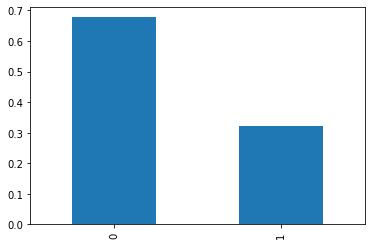

In [53]:
# check how imbalanced the target variable is

target_pcts = df_X.subject_injured.value_counts(normalize=True) 
print(target_pcts)

target_pcts.plot(kind='bar')

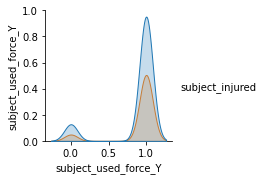

In [54]:
# create a helper function for plotting feature(s) vs target variable 

def plot_features(df, sample_size=500):
    
    sample = (df.sample(1000, random_state=44)) 
    sns.pairplot(sample,hue='subject_injured', plot_kws=dict(alpha=.3, edgecolor='none'))

plot_features(df_X[['subject_used_force_Y','subject_injured']])

In [55]:
X_1 = np.array(df_X['subject_used_force_Y']).reshape(-1,1)
y = np.array(df_X['subject_injured'])

In [56]:
y.shape

(13230,)

In [57]:
X_1.shape

(13230, 1)

In [58]:
# split data into training/validation and test data

X_tr_val, X_te, y_tr_val, y_te = train_test_split(X_1, y, test_size=0.2, random_state=42)

In [59]:
# simple logistic regression

lr = LogisticRegression(solver='lbfgs')
lr.fit(X_tr_val, y_tr_val)

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_results = cross_validate(lr, X_tr_val, y_tr_val, cv=kf, scoring='recall')

y_pred = lr.predict(X_tr_val)

print(f"recall: {(cv_results['test_score'])}")
print("")
print(f"mean recall: {(np.mean(cv_results['test_score'])):.3f}")
print("")
print(f"f2 score: {fbeta_score(y_tr_val, y_pred, beta=2):.3f}")

recall: [0. 0. 0. 0. 0.]

mean recall: 0.000

f2 score: 0.000


# Feature engineering to improve the model

## Create second feature -> the type of force used by a member of service

In [60]:
incidents['forcetype'].value_counts()

Physical Force              10172
Electrical Weapon            2855
OC Spray                      259
Impact Weapon                 142
Firearm                        88
Restraining Mesh Blanket        8
Police Canine                   3
Name: forcetype, dtype: int64

In [61]:
incidents = pd.get_dummies(incidents, columns=['forcetype'], drop_first=True)

In [62]:
df_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13230 entries, 0 to 13229
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   subject_id            13230 non-null  int64
 1   tri_incident_number   13230 non-null  int64
 2   subject_used_force_Y  13230 non-null  uint8
 3   subject_injured       13230 non-null  int64
dtypes: int64(3), uint8(1)
memory usage: 426.4 KB


In [63]:
incidents_tri_forcetype = incidents[['tri_incident_number','forcetype_Firearm','forcetype_Impact Weapon',
                                     'forcetype_OC Spray','forcetype_Physical Force','forcetype_Police Canine',
                                     'forcetype_Restraining Mesh Blanket']]

df_X = df_X.merge(incidents_tri_forcetype, on='tri_incident_number')

In [64]:
df_X.shape

(13230, 10)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


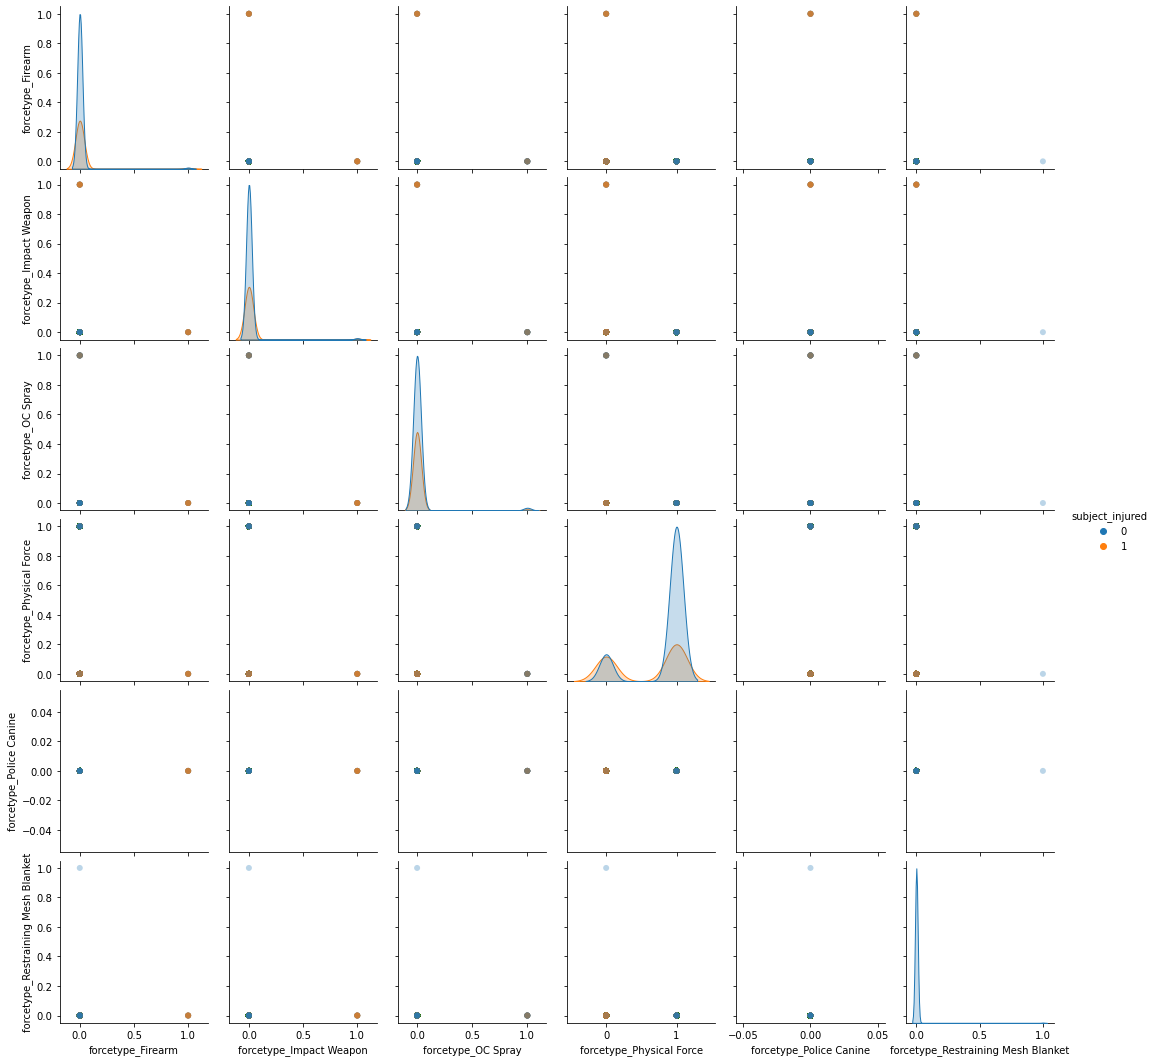

In [65]:
plot_features(df_X[['forcetype_Firearm','forcetype_Impact Weapon','forcetype_OC Spray','forcetype_Physical Force',
                    'forcetype_Police Canine','forcetype_Restraining Mesh Blanket','subject_injured']])

## Second model

In [66]:
X_2 = np.array(df_X[['subject_used_force_Y','forcetype_Firearm','forcetype_Impact Weapon','forcetype_OC Spray',
                    'forcetype_Physical Force','forcetype_Police Canine',
                    'forcetype_Restraining Mesh Blanket']])

In [67]:
# split data into training/validation and test data

X_tr_val_2, X_te_2, y_tr_val_2, y_te_2 = train_test_split(X_2, y, test_size=0.2, random_state=42)

In [68]:
# logistic regression with two features

lr_2 = LogisticRegression(solver='lbfgs')
lr_2.fit(X_tr_val_2, y_tr_val_2)

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_results = cross_validate(lr_2, X_tr_val_2, y_tr_val_2, cv=kf, scoring='recall')

y_pred_2 = lr_2.predict(X_tr_val_2)

print(f"recall: {(cv_results['test_score'])}")
print("")
print(f"mean recall: {(np.mean(cv_results['test_score'])):.3f}")
print("")
print(f"f2 score: {fbeta_score(y_tr_val_2, y_pred_2, beta=2):.3f}")

recall: [0.35460993 0.38880249 0.33773862 0.36402878 0.35312024]

mean recall: 0.360

f2 score: 0.390


## Create third feature -> whether 1+ member of service got injured

In [69]:
members.columns

Index(['tri_incident_number', 'forcetype', 'injurylevel', 'member_injured',
       'rank_grouped', 'assignment', 'member_gender', 'race'],
      dtype='object')

In [70]:
members['member_injured'].value_counts()

N    25794
Y     5463
Name: member_injured, dtype: int64

In [71]:
members['member_injured_rev'] = members['member_injured'].apply(lambda x: 1 if x == 'Y' else 0)
members_tri_member_injured = (members.groupby('tri_incident_number',as_index=False)['member_injured_rev'].sum())

member_injured_feature = ['num_members_injured']

members_tri_member_injured.columns = ['tri_incident_number'] + member_injured_feature

df_X = df_X.merge(members_tri_member_injured, on='tri_incident_number')

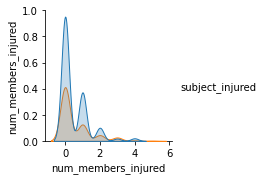

In [72]:
plot_features(df_X[['num_members_injured','subject_injured']])

## Third model

In [73]:
X_3 = np.array(df_X[['subject_used_force_Y','forcetype_Firearm','forcetype_Impact Weapon','forcetype_OC Spray',
                    'forcetype_Physical Force','forcetype_Police Canine',
                    'forcetype_Restraining Mesh Blanket','num_members_injured']])

In [74]:
# split data into training/validation and test data

X_tr_val_3, X_te_3, y_tr_val_3, y_te_3 = train_test_split(X_3, y, test_size=0.2, random_state=42)

In [75]:
# logistic regression with three features

lr_3 = LogisticRegression(solver='lbfgs')
lr_3.fit(X_tr_val_3, y_tr_val_3)

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_results = cross_validate(lr_3, X_tr_val_3, y_tr_val_3, cv=kf, scoring='recall')

y_pred_3 = lr_3.predict(X_tr_val_3)

print(f"recall: {(cv_results['test_score'])}")
print("")
print(f"mean recall: {(np.mean(cv_results['test_score'])):.3f}")
print("")
print(f"f2 score: {fbeta_score(y_tr_val_3, y_pred_3, beta=2):.3f}")

recall: [0.35460993 0.38880249 0.33773862 0.36115108 0.35312024]

mean recall: 0.359

f2 score: 0.390


# Create fourth feature -> patrol_borough

In [76]:
incidents.columns

Index(['tri_incident_number', 'incident_pct', 'patrol_borough',
       'basisforencounter', 'occurrence_date_rev', 'year', 'month',
       'forcetype_Firearm', 'forcetype_Impact Weapon', 'forcetype_OC Spray',
       'forcetype_Physical Force', 'forcetype_Police Canine',
       'forcetype_Restraining Mesh Blanket'],
      dtype='object')

In [77]:
incidents = pd.get_dummies(incidents, columns=['patrol_borough'], drop_first=True)

In [78]:
incidents.columns

Index(['tri_incident_number', 'incident_pct', 'basisforencounter',
       'occurrence_date_rev', 'year', 'month', 'forcetype_Firearm',
       'forcetype_Impact Weapon', 'forcetype_OC Spray',
       'forcetype_Physical Force', 'forcetype_Police Canine',
       'forcetype_Restraining Mesh Blanket', 'patrol_borough_PBBS',
       'patrol_borough_PBBX', 'patrol_borough_PBMN', 'patrol_borough_PBMS',
       'patrol_borough_PBQN', 'patrol_borough_PBQS', 'patrol_borough_PBSI'],
      dtype='object')

In [79]:
incidents_tri_patrol_borough = incidents[['tri_incident_number','patrol_borough_PBBS','patrol_borough_PBBX',
                                     'patrol_borough_PBMN', 'patrol_borough_PBMS','patrol_borough_PBQN',
                                     'patrol_borough_PBQS', 'patrol_borough_PBSI']]

df_X = df_X.merge(incidents_tri_patrol_borough, on='tri_incident_number')

In [80]:
df_X.columns

Index(['subject_id', 'tri_incident_number', 'subject_used_force_Y',
       'subject_injured', 'forcetype_Firearm', 'forcetype_Impact Weapon',
       'forcetype_OC Spray', 'forcetype_Physical Force',
       'forcetype_Police Canine', 'forcetype_Restraining Mesh Blanket',
       'num_members_injured', 'patrol_borough_PBBS', 'patrol_borough_PBBX',
       'patrol_borough_PBMN', 'patrol_borough_PBMS', 'patrol_borough_PBQN',
       'patrol_borough_PBQS', 'patrol_borough_PBSI'],
      dtype='object')

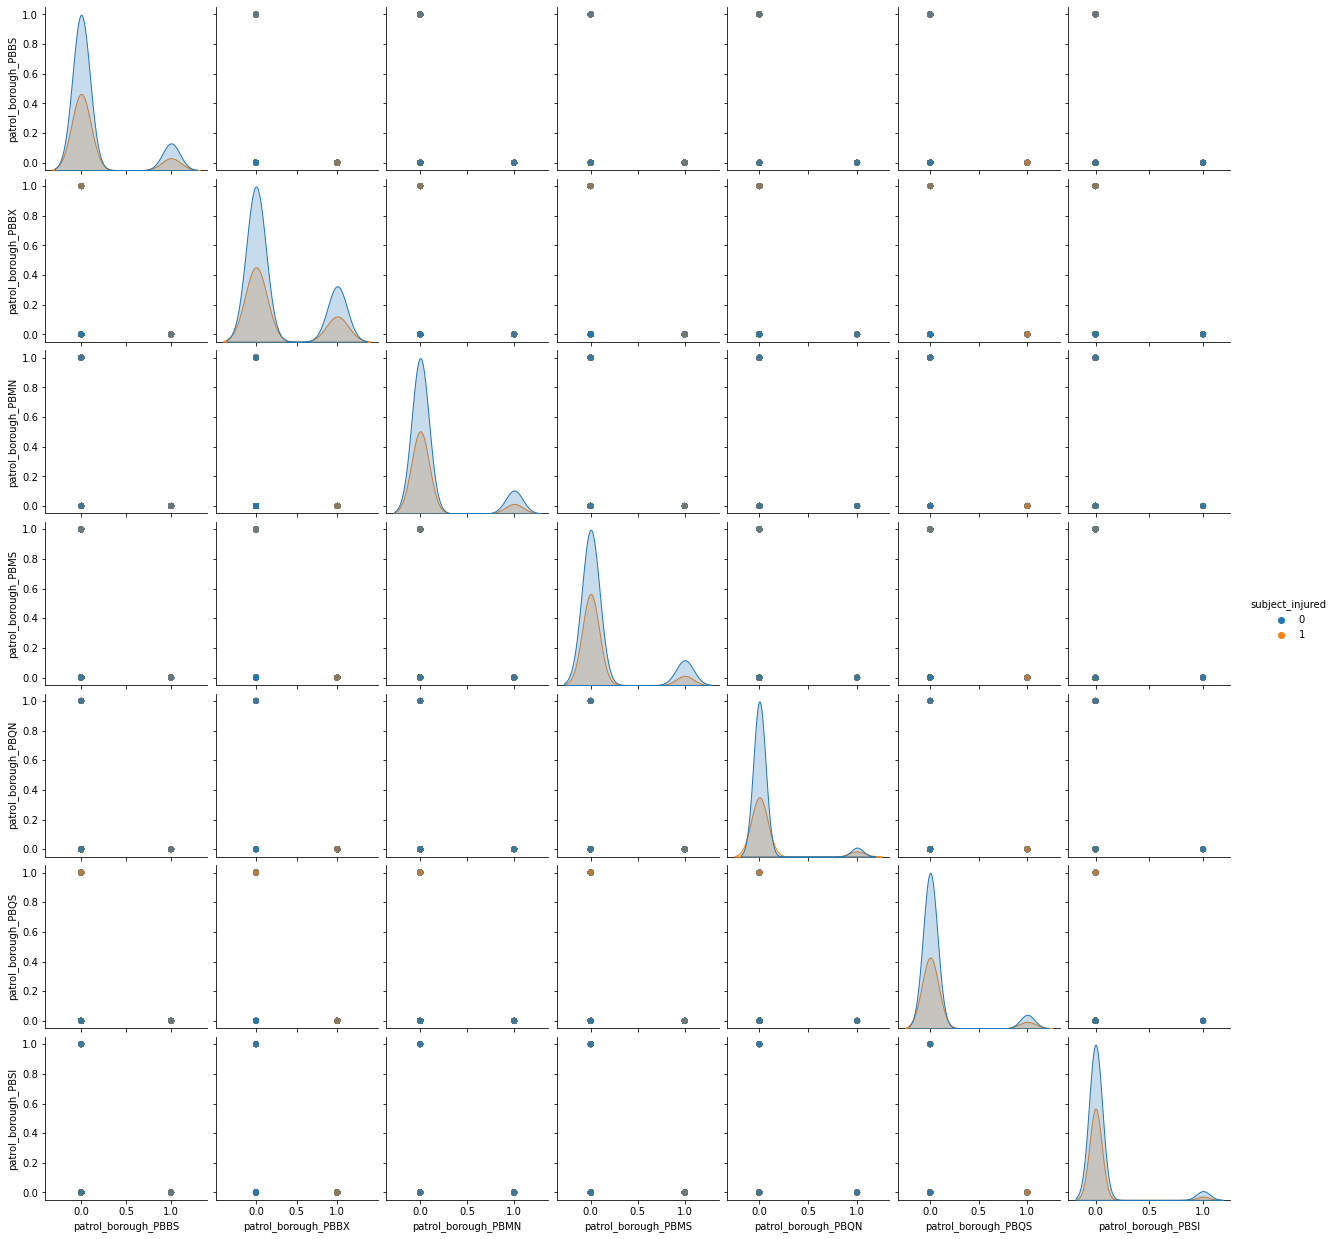

In [81]:
plot_features(df_X[['subject_injured','patrol_borough_PBBS', 'patrol_borough_PBBX',
       'patrol_borough_PBMN', 'patrol_borough_PBMS', 'patrol_borough_PBQN',
       'patrol_borough_PBQS', 'patrol_borough_PBSI']])

## Fourth model

In [82]:
X_4 = df_X[['subject_used_force_Y','forcetype_Firearm', 'forcetype_Impact Weapon',
       'forcetype_OC Spray', 'forcetype_Physical Force',
       'forcetype_Police Canine', 'forcetype_Restraining Mesh Blanket',
       'num_members_injured', 'patrol_borough_PBBS', 'patrol_borough_PBBX',
       'patrol_borough_PBMN', 'patrol_borough_PBMS', 'patrol_borough_PBQN',
       'patrol_borough_PBQS', 'patrol_borough_PBSI']]

In [83]:
# split data into training/validation and test data

X_tr_val_4, X_te_4, y_tr_val_4, y_te_4 = train_test_split(X_4, y, test_size=0.2, random_state=42)

In [84]:
# logistic regression with three features

lr_4 = LogisticRegression(solver='lbfgs')
lr_4.fit(X_tr_val_4, y_tr_val_4)

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_results = cross_validate(lr_4, X_tr_val_4, y_tr_val_4, cv=kf, scoring='recall')

y_pred_4 = lr_4.predict(X_tr_val_4)

print(f"recall: {(cv_results['test_score'])}")
print("")
print(f"mean recall: {(np.mean(cv_results['test_score'])):.3f}")
print("")
print(f"f2 score: {fbeta_score(y_tr_val_4, y_pred_4, beta=2):.3f}")

recall: [0.34893617 0.38724728 0.33773862 0.35395683 0.35312024]

mean recall: 0.356

f2 score: 0.390


# Create fifth feature -> subject's race

In [85]:
subjects_df.columns

Index(['subject_id', 'tri_incident_number', 'subject_injury_level',
       'subject_injured', 'age', 'subject_race', 'subject_gender',
       'force_against_mos', 'subject_used_force_Y'],
      dtype='object')

In [86]:
subject_race = pd.get_dummies(subjects_df.subject_race, prefix='subject_race').drop('subject_race_UNK/OTH',axis=1)

In [87]:
subject_race.columns

Index(['subject_race_AMER INDIAN', 'subject_race_ASIAN', 'subject_race_BLACK',
       'subject_race_HISPANIC', 'subject_race_WHITE'],
      dtype='object')

In [88]:
subjects_tri_race = pd.concat([subjects_df.subject_id,subject_race],axis=1)

df_X = df_X.merge(subjects_tri_race, on='subject_id')

In [89]:
df_X.columns

Index(['subject_id', 'tri_incident_number', 'subject_used_force_Y',
       'subject_injured', 'forcetype_Firearm', 'forcetype_Impact Weapon',
       'forcetype_OC Spray', 'forcetype_Physical Force',
       'forcetype_Police Canine', 'forcetype_Restraining Mesh Blanket',
       'num_members_injured', 'patrol_borough_PBBS', 'patrol_borough_PBBX',
       'patrol_borough_PBMN', 'patrol_borough_PBMS', 'patrol_borough_PBQN',
       'patrol_borough_PBQS', 'patrol_borough_PBSI',
       'subject_race_AMER INDIAN', 'subject_race_ASIAN', 'subject_race_BLACK',
       'subject_race_HISPANIC', 'subject_race_WHITE'],
      dtype='object')

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


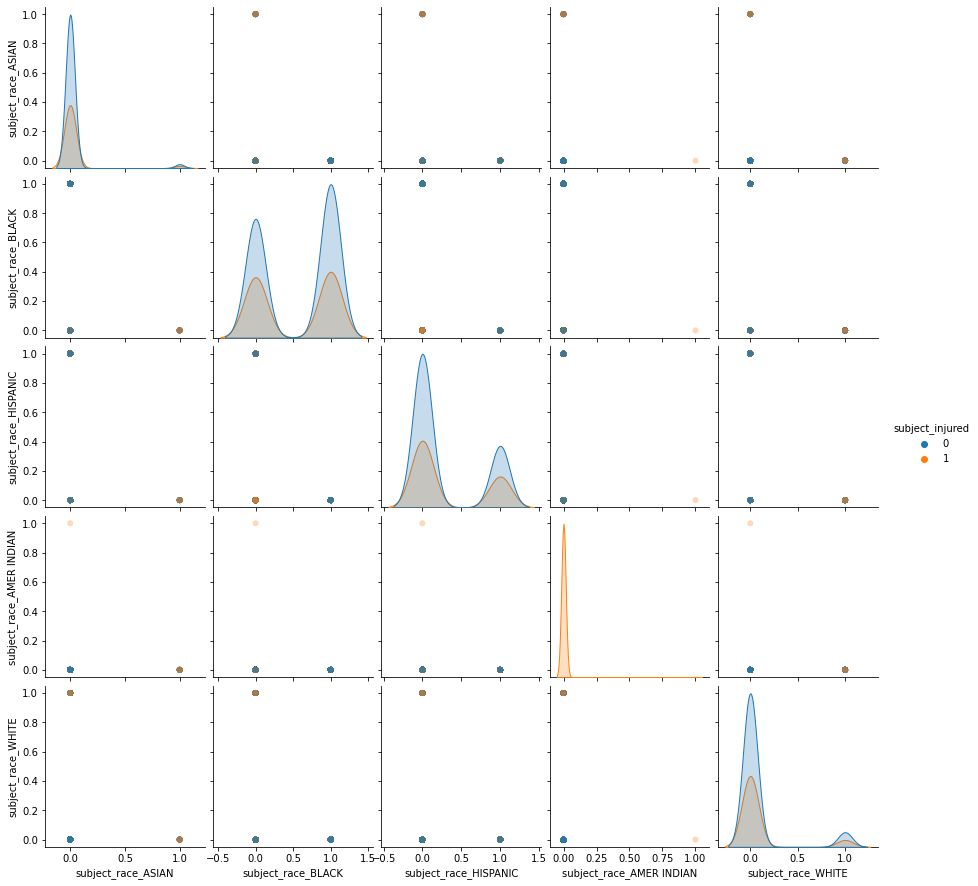

In [90]:
plot_features(df_X[['subject_injured','subject_race_ASIAN',
       'subject_race_BLACK', 'subject_race_HISPANIC', 'subject_race_AMER INDIAN',
       'subject_race_WHITE']])

# Create sixth feature - the type of force used by the subject

In [91]:
subjects_df.columns

Index(['subject_id', 'tri_incident_number', 'subject_injury_level',
       'subject_injured', 'age', 'subject_race', 'subject_gender',
       'force_against_mos', 'subject_used_force_Y'],
      dtype='object')

In [92]:
subjects_df['force_against_mos'].value_counts()

Physical Force        11534
No Force               1400
Displayed Weapon        157
Impact Weapon           100
Firearm                  22
Cutting Instrument       17
Name: force_against_mos, dtype: int64

In [93]:
force_against_mos = pd.get_dummies(subjects_df.force_against_mos,prefix='force_against_mos').drop('force_against_mos_No Force',axis=1)

In [94]:
force_against_mos.columns

Index(['force_against_mos_Cutting Instrument',
       'force_against_mos_Displayed Weapon', 'force_against_mos_Firearm',
       'force_against_mos_Impact Weapon', 'force_against_mos_Physical Force'],
      dtype='object')

In [95]:
subjects_df.columns

Index(['subject_id', 'tri_incident_number', 'subject_injury_level',
       'subject_injured', 'age', 'subject_race', 'subject_gender',
       'force_against_mos', 'subject_used_force_Y'],
      dtype='object')

In [96]:
subjects_tri_forcetype = pd.concat([subjects_df.subject_id,force_against_mos],axis=1)

df_X = df_X.merge(subjects_tri_forcetype, on='subject_id')

In [97]:
subjects_tri_forcetype.columns

Index(['subject_id', 'force_against_mos_Cutting Instrument',
       'force_against_mos_Displayed Weapon', 'force_against_mos_Firearm',
       'force_against_mos_Impact Weapon', 'force_against_mos_Physical Force'],
      dtype='object')

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


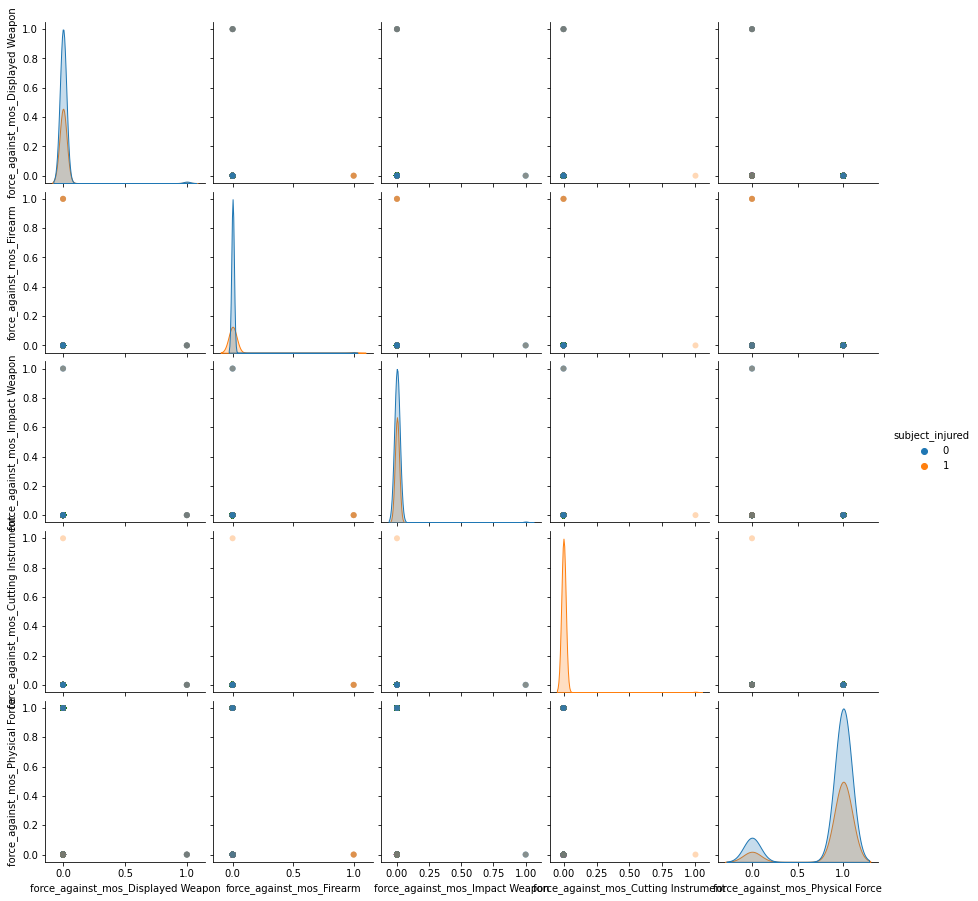

In [98]:
plot_features(df_X[['subject_injured','force_against_mos_Displayed Weapon',
                                      'force_against_mos_Firearm','force_against_mos_Impact Weapon',
                                      'force_against_mos_Cutting Instrument','force_against_mos_Physical Force']])

## Fifth model

In [99]:
X_5 = df_X[['forcetype_Firearm','forcetype_Impact Weapon','forcetype_OC Spray',
                    'forcetype_Physical Force','forcetype_Police Canine',
                    'forcetype_Restraining Mesh Blanket','force_against_mos_Displayed Weapon',
                     'force_against_mos_Firearm','force_against_mos_Impact Weapon',
                     'force_against_mos_Cutting Instrument','force_against_mos_Physical Force',
                     'subject_race_ASIAN','subject_race_BLACK', 'subject_race_HISPANIC',
                     'subject_race_AMER INDIAN','subject_race_WHITE','patrol_borough_PBBS', 'patrol_borough_PBBX',
                     'patrol_borough_PBMN', 'patrol_borough_PBMS', 'patrol_borough_PBQN',
                     'patrol_borough_PBQS', 'patrol_borough_PBSI']]

In [100]:
# split data into training/validation and test data

X_tr_val_5, X_te_5, y_tr_val_5, y_te_5 = train_test_split(X_5, y, test_size=0.2, random_state=42)

In [101]:
# logistic regression with four features: 
    # type of force mos used (if any)
    # type of force subject used (if any)
    # subject's race
    # patrol borough

lr_5 = LogisticRegression(solver='lbfgs',max_iter=10000)
lr_5.fit(X_tr_val_5, y_tr_val_5)

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_results = cross_validate(lr_5, X_tr_val_5, y_tr_val_5, cv=kf, scoring='recall')

y_pred_5 = lr_5.predict(X_tr_val_5)

print(f"recall: {(cv_results['test_score'])}")
print("")
print(f"mean recall: {(np.mean(cv_results['test_score'])):.3f}")
print("")
print(f"f2 score: {fbeta_score(y_tr_val_5, y_pred_5, beta=2):.3f}")

recall: [0.39007092 0.42612753 0.37591777 0.38273381 0.38356164]

mean recall: 0.392

f2 score: 0.419


# Create seventh feature -> basis for encounter

In [102]:
incidents.columns

Index(['tri_incident_number', 'incident_pct', 'basisforencounter',
       'occurrence_date_rev', 'year', 'month', 'forcetype_Firearm',
       'forcetype_Impact Weapon', 'forcetype_OC Spray',
       'forcetype_Physical Force', 'forcetype_Police Canine',
       'forcetype_Restraining Mesh Blanket', 'patrol_borough_PBBS',
       'patrol_borough_PBBX', 'patrol_borough_PBMN', 'patrol_borough_PBMS',
       'patrol_borough_PBQN', 'patrol_borough_PBQS', 'patrol_borough_PBSI'],
      dtype='object')

In [103]:
incidents['basisforencounter'].value_counts()

CRIME/VIOLATION IN PROGRESS              5279
PERSON IN CRISIS                         3235
OTHER                                    1273
PRISONER                                 1092
CROWD CONTROL                             526
VTL INFRACTION                            441
WANTED SUSPECT (E.G. WARRANT, I CARD)     437
PAST CRIME/VIOLATION                      402
SUSPICIOUS ACTIVITY                       226
DETECTIVE INVESTIGATION                   140
TRANSIT EJECTION                          104
NON-CRIME CALLS FOR SERVICE                95
ORDER OF PROTECTION                        95
IN CUSTODY INJURY                          71
HOME VISIT                                 38
AMBUSH OF MEMBER                           23
SEARCH WARRANT                             23
ANIMAL CONDITION                           14
HOSTAGE/BARRICADED                         13
Name: basisforencounter, dtype: int64

In [104]:
incidents = pd.get_dummies(incidents, columns=['basisforencounter'], drop_first=True)

In [105]:
incidents.columns

Index(['tri_incident_number', 'incident_pct', 'occurrence_date_rev', 'year',
       'month', 'forcetype_Firearm', 'forcetype_Impact Weapon',
       'forcetype_OC Spray', 'forcetype_Physical Force',
       'forcetype_Police Canine', 'forcetype_Restraining Mesh Blanket',
       'patrol_borough_PBBS', 'patrol_borough_PBBX', 'patrol_borough_PBMN',
       'patrol_borough_PBMS', 'patrol_borough_PBQN', 'patrol_borough_PBQS',
       'patrol_borough_PBSI', 'basisforencounter_ANIMAL CONDITION',
       'basisforencounter_CRIME/VIOLATION IN PROGRESS',
       'basisforencounter_CROWD CONTROL',
       'basisforencounter_DETECTIVE INVESTIGATION',
       'basisforencounter_HOME VISIT', 'basisforencounter_HOSTAGE/BARRICADED',
       'basisforencounter_IN CUSTODY INJURY',
       'basisforencounter_NON-CRIME CALLS FOR SERVICE',
       'basisforencounter_ORDER OF PROTECTION', 'basisforencounter_OTHER',
       'basisforencounter_PAST CRIME/VIOLATION',
       'basisforencounter_PERSON IN CRISIS', 'basisfore

In [106]:
incidents_tri_basis_encounter = incidents[['tri_incident_number','basisforencounter_ANIMAL CONDITION',
       'basisforencounter_CRIME/VIOLATION IN PROGRESS',
       'basisforencounter_CROWD CONTROL',
       'basisforencounter_DETECTIVE INVESTIGATION',
       'basisforencounter_HOME VISIT', 'basisforencounter_HOSTAGE/BARRICADED',
       'basisforencounter_IN CUSTODY INJURY',
       'basisforencounter_NON-CRIME CALLS FOR SERVICE',
       'basisforencounter_ORDER OF PROTECTION', 'basisforencounter_OTHER',
       'basisforencounter_PAST CRIME/VIOLATION',
       'basisforencounter_PERSON IN CRISIS', 'basisforencounter_PRISONER',
       'basisforencounter_SEARCH WARRANT',
       'basisforencounter_SUSPICIOUS ACTIVITY',
       'basisforencounter_TRANSIT EJECTION',
       'basisforencounter_VTL INFRACTION',
       'basisforencounter_WANTED SUSPECT (E.G. WARRANT, I CARD)']]

df_X = df_X.merge(incidents_tri_basis_encounter, on='tri_incident_number')

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


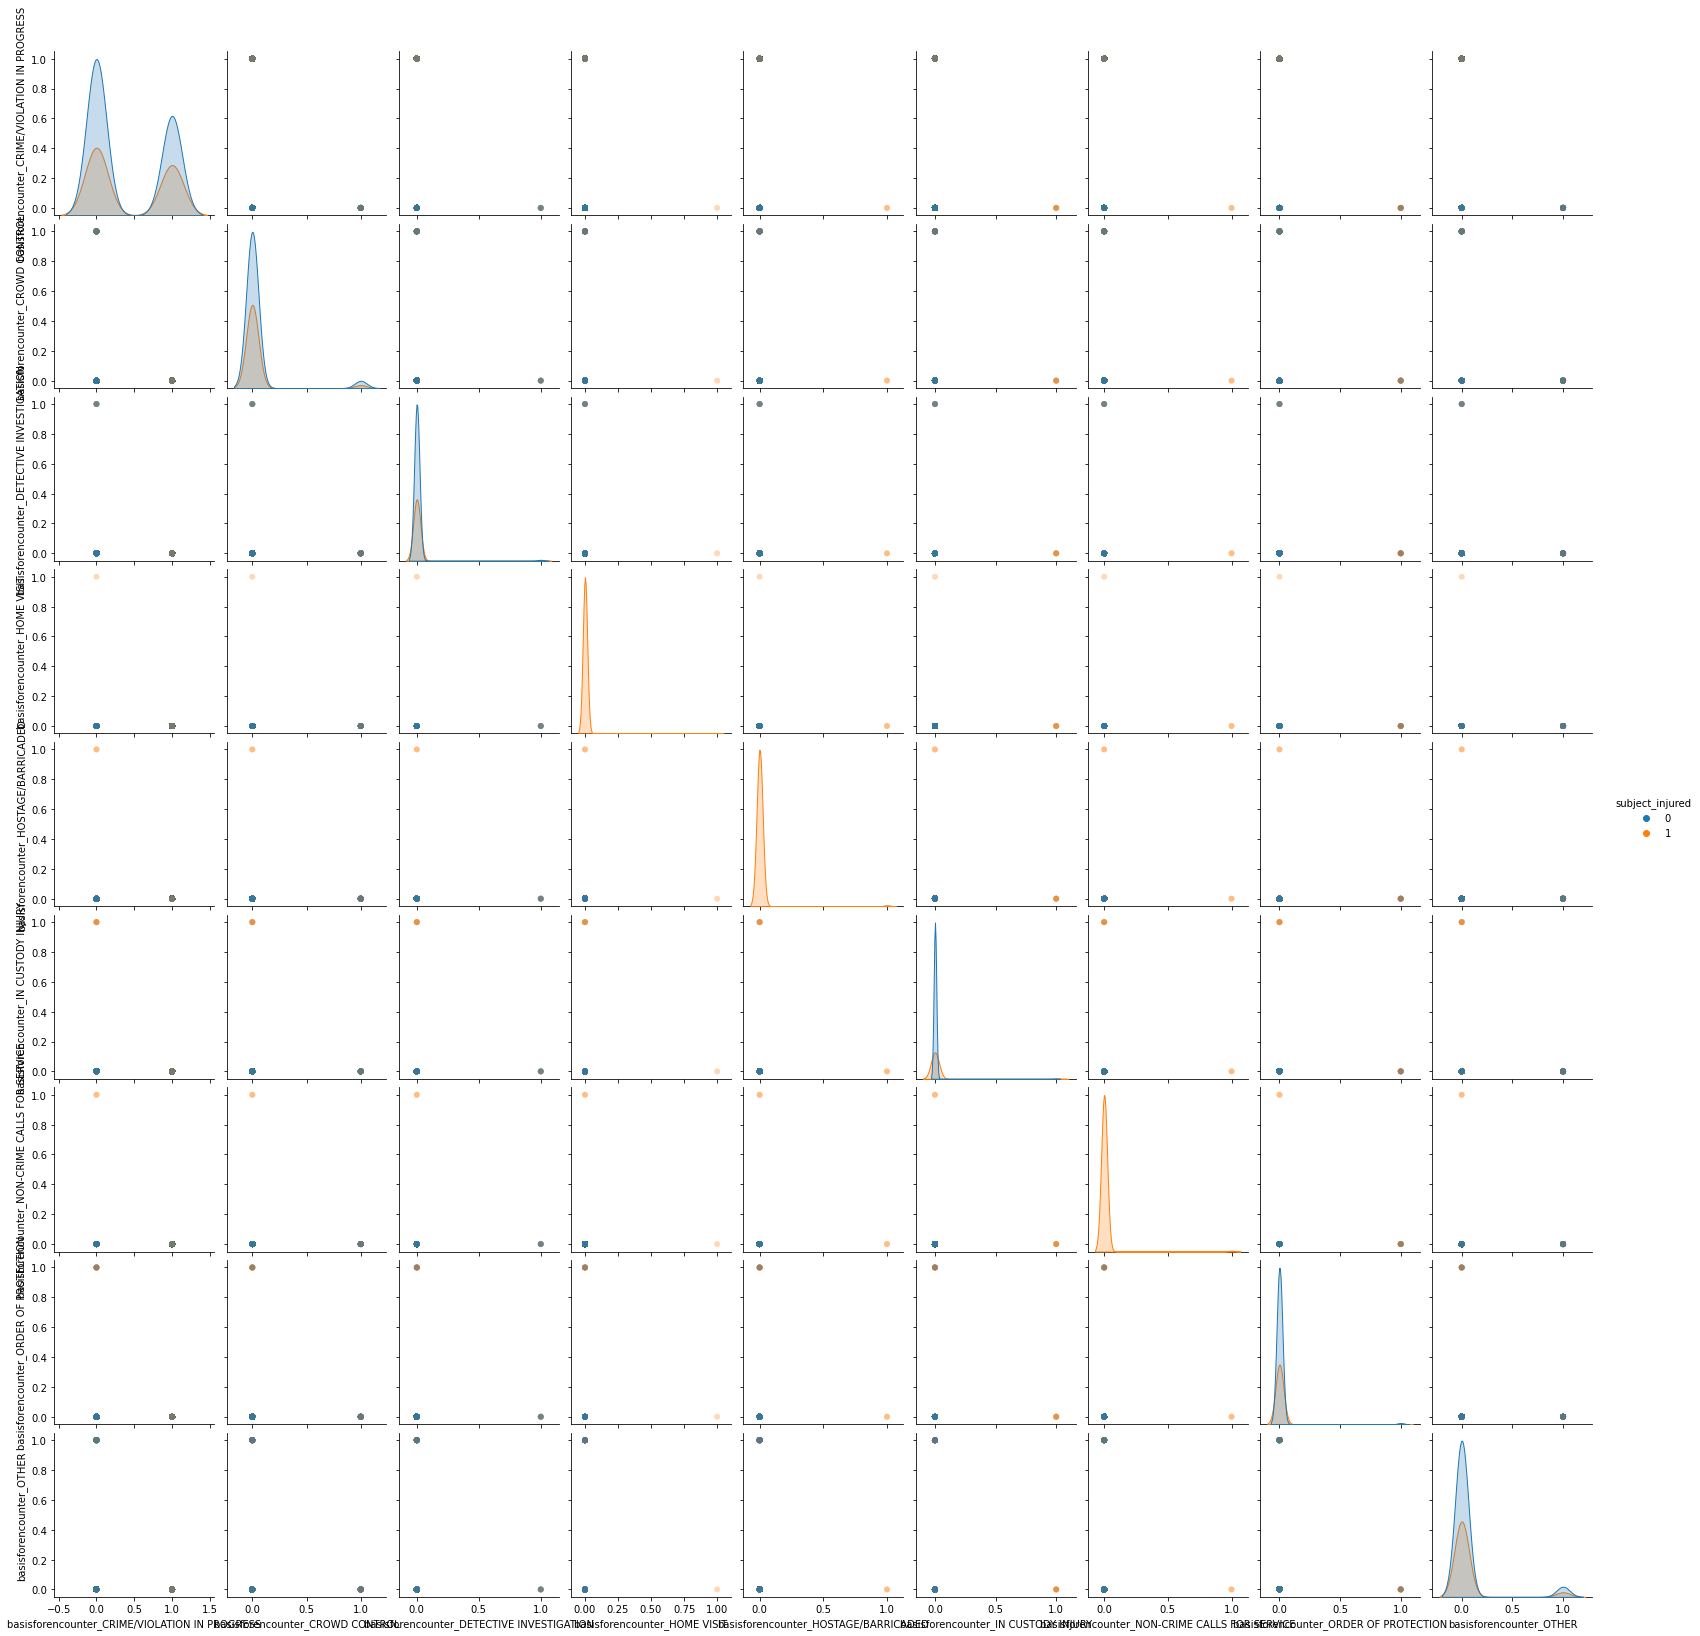

In [107]:
plot_features(df_X[['subject_injured','basisforencounter_CRIME/VIOLATION IN PROGRESS',
       'basisforencounter_CROWD CONTROL',
       'basisforencounter_DETECTIVE INVESTIGATION',
       'basisforencounter_HOME VISIT', 'basisforencounter_HOSTAGE/BARRICADED',
       'basisforencounter_IN CUSTODY INJURY',
       'basisforencounter_NON-CRIME CALLS FOR SERVICE',
       'basisforencounter_ORDER OF PROTECTION', 'basisforencounter_OTHER']])

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


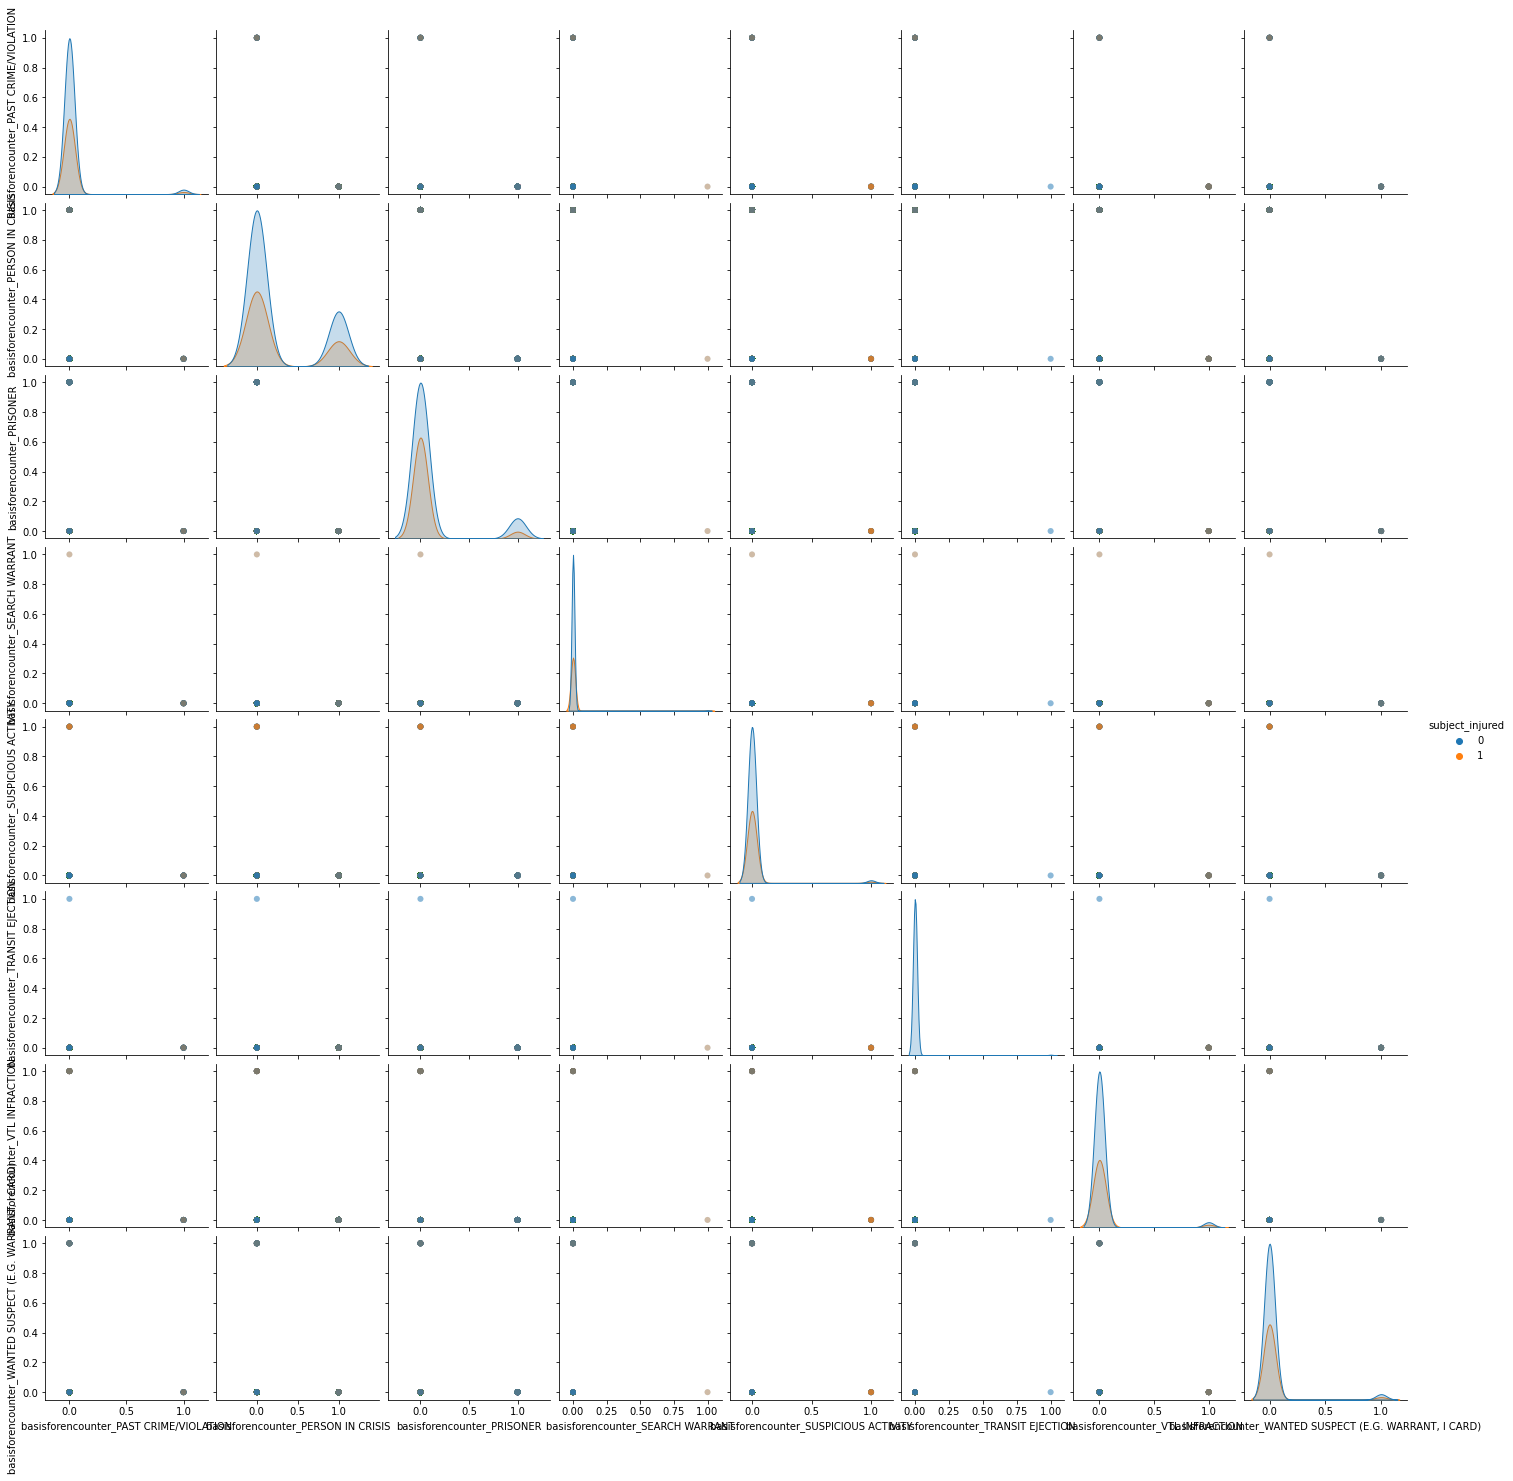

In [108]:
plot_features(df_X[['subject_injured','basisforencounter_PAST CRIME/VIOLATION',
       'basisforencounter_PERSON IN CRISIS', 'basisforencounter_PRISONER',
       'basisforencounter_SEARCH WARRANT',
       'basisforencounter_SUSPICIOUS ACTIVITY',
       'basisforencounter_TRANSIT EJECTION',
       'basisforencounter_VTL INFRACTION',
       'basisforencounter_WANTED SUSPECT (E.G. WARRANT, I CARD)']])

## Sixth model

In [109]:
X_6 = df_X[['forcetype_Firearm','forcetype_Impact Weapon','forcetype_OC Spray',
                    'forcetype_Physical Force','forcetype_Police Canine',
                    'forcetype_Restraining Mesh Blanket','force_against_mos_Displayed Weapon',
                     'force_against_mos_Firearm','force_against_mos_Impact Weapon',
                     'force_against_mos_Cutting Instrument','force_against_mos_Physical Force','subject_race_ASIAN','subject_race_BLACK', 'subject_race_HISPANIC',
                     'subject_race_AMER INDIAN','subject_race_WHITE','patrol_borough_PBBS', 'patrol_borough_PBBX',
                     'patrol_borough_PBMN', 'patrol_borough_PBMS', 'patrol_borough_PBQN',
                     'patrol_borough_PBQS', 'patrol_borough_PBSI','basisforencounter_ANIMAL CONDITION',
                     'basisforencounter_CRIME/VIOLATION IN PROGRESS','basisforencounter_CROWD CONTROL',
                     'basisforencounter_DETECTIVE INVESTIGATION','basisforencounter_HOME VISIT',
                     'basisforencounter_HOSTAGE/BARRICADED','basisforencounter_IN CUSTODY INJURY',
                     'basisforencounter_NON-CRIME CALLS FOR SERVICE','basisforencounter_ORDER OF PROTECTION',
                     'basisforencounter_OTHER','basisforencounter_PAST CRIME/VIOLATION',
                     'basisforencounter_PERSON IN CRISIS', 'basisforencounter_PRISONER',
                     'basisforencounter_SEARCH WARRANT','basisforencounter_SUSPICIOUS ACTIVITY',
                     'basisforencounter_TRANSIT EJECTION','basisforencounter_VTL INFRACTION',
                     'basisforencounter_WANTED SUSPECT (E.G. WARRANT, I CARD)']]

In [110]:
# split data into training/validation and test data

X_tr_val_6, X_te_6, y_tr_val_6, y_te_6 = train_test_split(X_6, y, test_size=0.2, random_state=42)

In [111]:
# logistic regression with 

lr_6 = LogisticRegression(solver='lbfgs',max_iter=10000)
lr_6.fit(X_tr_val_6, y_tr_val_6)

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_results = cross_validate(lr_6, X_tr_val_6, y_tr_val_6, cv=kf, scoring='recall')

y_pred_6 = lr_6.predict(X_tr_val_6)

print(f"recall: {(cv_results['test_score'])}")
print("")
print(f"mean recall: {(np.mean(cv_results['test_score'])):.3f}")
print("")
print(f"f2 score: {fbeta_score(y_tr_val_6, y_pred_6, beta=2):.3f}")

recall: [0.34468085 0.39657854 0.34508076 0.37410072 0.36834094]

mean recall: 0.366

f2 score: 0.410


# Create eighth feature -> number of member(s) of service

In [112]:
members.columns

Index(['tri_incident_number', 'forcetype', 'injurylevel', 'member_injured',
       'rank_grouped', 'assignment', 'member_gender', 'race',
       'member_injured_rev'],
      dtype='object')

In [113]:
# add column to assign index to each member of service
members.reset_index(inplace=True)
members = members.rename(columns = {'index':'mos_id'})

In [114]:
members_tri_member_count = (members.groupby('tri_incident_number',as_index=False)['mos_id'].count())

member_count_feature = ['num_members']

members_tri_member_count.columns = ['tri_incident_number'] + member_count_feature

df_X = df_X.merge(members_tri_member_count, on='tri_incident_number')

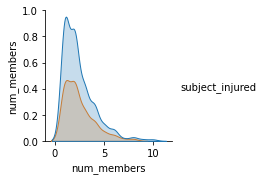

In [115]:
plot_features(df_X[['subject_injured','num_members']])

## Seventh model

In [116]:
X_7 = df_X[['num_members','forcetype_Firearm','forcetype_Impact Weapon','forcetype_OC Spray',
                    'forcetype_Physical Force','forcetype_Police Canine',
                    'forcetype_Restraining Mesh Blanket','force_against_mos_Displayed Weapon',
                     'force_against_mos_Firearm','force_against_mos_Impact Weapon',
                     'force_against_mos_Cutting Instrument','force_against_mos_Physical Force','subject_race_ASIAN','subject_race_BLACK', 'subject_race_HISPANIC',
                     'subject_race_AMER INDIAN','subject_race_WHITE','patrol_borough_PBBS', 'patrol_borough_PBBX',
                     'patrol_borough_PBMN', 'patrol_borough_PBMS', 'patrol_borough_PBQN',
                     'patrol_borough_PBQS', 'patrol_borough_PBSI']]

In [117]:
# split data into training/validation and test data

X_tr_val_7, X_te_7, y_tr_val_7, y_te_7 = train_test_split(X_7, y, test_size=0.2, random_state=42)

In [118]:
# logistic regression 

lr_7 = LogisticRegression(solver='lbfgs',max_iter=10000)
lr_7.fit(X_tr_val_7, y_tr_val_7)

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_results = cross_validate(lr_7, X_tr_val_7, y_tr_val_7, cv=kf, scoring='recall')

y_pred_7 = lr_7.predict(X_tr_val_7)

print(f"recall: {(cv_results['test_score'])}")
print("")
print(f"mean recall: {(np.mean(cv_results['test_score'])):.3f}")
print("")
print(f"f2 score: {fbeta_score(y_tr_val_7, y_pred_7, beta=2):.3f}")

recall: [0.3858156  0.42768274 0.36270191 0.38273381 0.38660578]

mean recall: 0.389

f2 score: 0.420


# Create ninth feature -> subject's age

In [119]:
subjects_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13230 entries, 0 to 13229
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   subject_id            13230 non-null  int64  
 1   tri_incident_number   13230 non-null  int64  
 2   subject_injury_level  13230 non-null  object 
 3   subject_injured       13230 non-null  int64  
 4   age                   12692 non-null  float64
 5   subject_race          13230 non-null  object 
 6   subject_gender        13230 non-null  object 
 7   force_against_mos     13230 non-null  object 
 8   subject_used_force_Y  13230 non-null  uint8  
dtypes: float64(1), int64(3), object(4), uint8(1)
memory usage: 839.9+ KB


In [120]:
subjects_df['age'].describe()

count    12692.000000
mean        30.765443
std         10.882068
min          2.000000
25%         23.000000
50%         29.000000
75%         37.000000
max         85.000000
Name: age, dtype: float64

In [121]:
# assign median age to rows with nan

subjects_df['age'].fillna(subjects_df['age'].median(),inplace=True)

In [122]:
subjects_age = subjects_df[['subject_id','age']]
subjects_age = subjects_age.rename(columns = {'age':'subject_age'})

In [123]:
df_X = df_X.merge(subjects_age,on='subject_id')

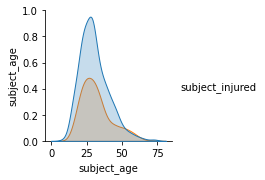

In [124]:
plot_features(df_X[['subject_injured','subject_age']])

## Eighth model

In [125]:
X_8 = df_X[['subject_age','num_members','forcetype_Firearm','forcetype_Impact Weapon','forcetype_OC Spray',
                    'forcetype_Physical Force','forcetype_Police Canine',
                    'forcetype_Restraining Mesh Blanket','force_against_mos_Displayed Weapon',
                     'force_against_mos_Firearm','force_against_mos_Impact Weapon',
                     'force_against_mos_Cutting Instrument','force_against_mos_Physical Force',
                     'subject_race_ASIAN','subject_race_BLACK', 'subject_race_HISPANIC',
                     'subject_race_AMER INDIAN','subject_race_WHITE']]

In [126]:
# split data into training/validation and test data

X_tr_val_8, X_te_8, y_tr_val_8, y_te_8 = train_test_split(X_8, y, test_size=0.2, random_state=42)

In [127]:
# logistic regression 

lr_8 = LogisticRegression(solver='lbfgs',max_iter=10000)
lr_8.fit(X_tr_val_8, y_tr_val_8)

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_results = cross_validate(lr_8, X_tr_val_8, y_tr_val_8, cv=kf, scoring='recall')

y_pred_8 = lr_8.predict(X_tr_val_8)

print(f"recall: {(cv_results['test_score'])}")
print("")
print(f"mean recall: {(np.mean(cv_results['test_score'])):.3f}")
print("")
print(f"f2 score: {fbeta_score(y_tr_val_8, y_pred_8, beta=2):.3f}")

recall: [0.38865248 0.437014   0.38179148 0.38129496 0.39117199]

mean recall: 0.396

f2 score: 0.424


# Create tenth feature -> whether the race of the subject and all mos is different

In [128]:
subjects['subject_race'].value_counts()

BLACK          7386
HISPANIC       3841
WHITE          1167
UNK/OTH         531
ASIAN           329
AMER INDIAN      29
Name: subject_race, dtype: int64

In [129]:
members['race'].value_counts()

WHITE          14767
HISPANIC       10001
BLACK           3775
ASIAN           2673
AMER INDIAN       25
OTH/UNK           16
Name: race, dtype: int64

In [130]:
# change 'OTH/UNK' category in members' race column so it matches the category in subjects' race column
members.loc[members.race == 'OTH/UNK', 'race'] = 'UNK/OTH'

In [131]:
# add column to assign index to each subject in subjects
subjects.reset_index(inplace=True)
subjects = subjects.rename(columns = {'index':'subject_id'})

In [132]:
# merge 
subjects_race = subjects[['subject_id','subject_race']]
df_X = df_X.merge(subjects_race,on='subject_id')

In [133]:
members_tri_race = (members.groupby('tri_incident_number', as_index=False)
               .agg({'race': (lambda x: set(x))})
               .rename(columns={'race': 'mos_race_set'}))

df_X = df_X.merge(members_tri_race, on='tri_incident_number')
df_X['subject_mos_race_diff'] = (df_X.apply(lambda row: row['subject_race'] not in row['mos_race_set'], axis=1).astype(int))

In [134]:
df_X = pd.get_dummies(df_X, columns=['subject_mos_race_diff'], drop_first=True)

In [135]:
# drop subject_race and mos_race_set columns that were only needed to create subject_mos_race_diff
df_X.drop(['subject_race','mos_race_set'],axis=1,inplace=True)

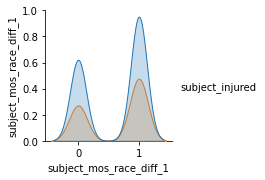

In [136]:
plot_features(df_X[['subject_injured','subject_mos_race_diff_1']])

## Ninth model

In [137]:
#list for cols to scale
cols_to_scale = ['num_members','subject_age','num_members_injured']

#create scaler, fit and scale selected data
scaler = StandardScaler()
df_X[cols_to_scale] = scaler.fit_transform(df_X[cols_to_scale])

In [138]:
df_X.columns

Index(['subject_id', 'tri_incident_number', 'subject_used_force_Y',
       'subject_injured', 'forcetype_Firearm', 'forcetype_Impact Weapon',
       'forcetype_OC Spray', 'forcetype_Physical Force',
       'forcetype_Police Canine', 'forcetype_Restraining Mesh Blanket',
       'num_members_injured', 'patrol_borough_PBBS', 'patrol_borough_PBBX',
       'patrol_borough_PBMN', 'patrol_borough_PBMS', 'patrol_borough_PBQN',
       'patrol_borough_PBQS', 'patrol_borough_PBSI',
       'subject_race_AMER INDIAN', 'subject_race_ASIAN', 'subject_race_BLACK',
       'subject_race_HISPANIC', 'subject_race_WHITE',
       'force_against_mos_Cutting Instrument',
       'force_against_mos_Displayed Weapon', 'force_against_mos_Firearm',
       'force_against_mos_Impact Weapon', 'force_against_mos_Physical Force',
       'basisforencounter_ANIMAL CONDITION',
       'basisforencounter_CRIME/VIOLATION IN PROGRESS',
       'basisforencounter_CROWD CONTROL',
       'basisforencounter_DETECTIVE INVESTIGATION

In [139]:
X_9 = df_X[['forcetype_Firearm', 'forcetype_Impact Weapon',
                     'forcetype_OC Spray', 'forcetype_Physical Force',
                     'forcetype_Police Canine', 'forcetype_Restraining Mesh Blanket',
                     'force_against_mos_Displayed Weapon',
                     'force_against_mos_Firearm', 'force_against_mos_Impact Weapon',
                     'force_against_mos_Cutting Instrument', 'force_against_mos_Physical Force',
                     'subject_race_ASIAN','subject_race_BLACK', 'subject_race_HISPANIC', 
                     'subject_race_AMER INDIAN','subject_race_WHITE', 'subject_age', 'subject_mos_race_diff_1']]

In [140]:
# split data into training/validation and test data

X_tr_val_9, X_te_9, y_tr_val_9, y_te_9 = train_test_split(X_9, y, test_size=0.2, random_state=42)

In [141]:
# logistic regression 

lr_9 = LogisticRegression(solver='lbfgs',max_iter=10000)
lr_9.fit(X_tr_val_9, y_tr_val_9)

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_results = cross_validate(lr_9, X_tr_val_9, y_tr_val_9, cv=kf, scoring='recall')

y_pred_9 = lr_9.predict(X_tr_val_9)

print(f"recall: {(cv_results['test_score'])}")
print("")
print(f"mean recall: {(np.mean(cv_results['test_score'])):.3f}")
print("")
print(f"f2 score: {fbeta_score(y_tr_val_9, y_pred_9, beta=2):.3f}")

recall: [0.38723404 0.43545879 0.38325991 0.37985612 0.39421613]

mean recall: 0.396

f2 score: 0.426


# Create eleventh feature -> number of subjects

In [142]:
subjects_count = (subjects_df.groupby('tri_incident_number',as_index=False)['subject_id']
                  .count().rename(columns={'subject_id': 'num_subjects'}))

In [143]:
df_X = df_X.merge(subjects_count,on='tri_incident_number')

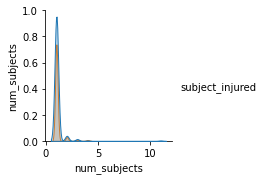

In [144]:
plot_features(df_X[['subject_injured','num_subjects']])

## Tenth model

In [145]:
#list for cols to scale
cols_to_scale = ['num_members','subject_age','num_members_injured','num_subjects']

#create scaler, fit and scale selected data
scaler = StandardScaler()
df_X[cols_to_scale] = scaler.fit_transform(df_X[cols_to_scale])

In [146]:
X_10 = df_X[['forcetype_Firearm', 'forcetype_Impact Weapon',
                     'forcetype_OC Spray', 'forcetype_Physical Force',
                     'forcetype_Police Canine', 'forcetype_Restraining Mesh Blanket',
                     'force_against_mos_Displayed Weapon',
                     'force_against_mos_Firearm', 'force_against_mos_Impact Weapon',
                     'force_against_mos_Cutting Instrument', 'force_against_mos_Physical Force',
                     'subject_race_ASIAN','subject_race_BLACK', 'subject_race_HISPANIC', 
                     'subject_race_AMER INDIAN','subject_race_WHITE']]

In [147]:
# split data into training/validation and test data

X_tr_val_10, X_te_10, y_tr_val_10, y_te_10 = train_test_split(X_10, y, test_size=0.2, random_state=42)

In [148]:
# logistic regression 

lr_10 = LogisticRegression(solver='lbfgs',max_iter=10000)
lr_10.fit(X_tr_val_10, y_tr_val_10)

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_results = cross_validate(lr_10, X_tr_val_10, y_tr_val_10, cv=kf, scoring='recall')

y_pred_10 = lr_10.predict(X_tr_val_10)

print(f"recall: {(cv_results['test_score'])}")
print("")
print(f"mean recall: {(np.mean(cv_results['test_score'])):.3f}")
print("")
print(f"f2 score: {fbeta_score(y_tr_val_10, y_pred_10, beta=2):.3f}")

recall: [0.39007092 0.44167963 0.3876652  0.3942446  0.3957382 ]

mean recall: 0.402

f2 score: 0.434


In [149]:
# get importance
importance = lr_10.coef_[0]

# create df of features and their importance levels
lr_10_feature_importance = pd.DataFrame({'feature': X_10.columns,
                   'importance': importance}).\
                    sort_values('importance', ascending = False)
lr_10_feature_importance

,feature,importance
14,subject_race_AMER INDIAN,2.360183
11,subject_race_ASIAN,2.115637
4,forcetype_Police Canine,0.752672
15,subject_race_WHITE,0.409557
13,subject_race_HISPANIC,0.328070
8,force_against_mos_Impact Weapon,0.321740
10,force_against_mos_Physical Force,0.175114
7,force_against_mos_Firearm,0.153109
12,subject_race_BLACK,0.115176
0,forcetype_Firearm,0.000467


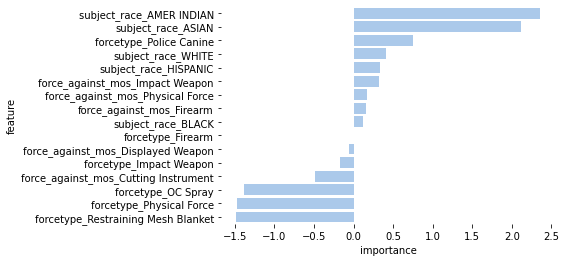

In [150]:
# plot the features and their importance levels

sns.set_color_codes("pastel")
sns.barplot(x="importance", y="feature", data=lr_10_feature_importance,
            label="Feature Importance", color="b")
sns.despine(left=True, bottom=True)

Note: the reference categories for each feature are below
- forcetype: Electrical Weapon
- force_against_mos: No Force
- subject_race: AMER INDIAN

Interpretation of the features:
- Non-NYPD subjects that experienced force in the form of a police canine or firearm are more likely to have gotten injured than those who experienced force in the form of an electrical weapon (i.e., taser)
- Non-NYPD subjects that experienced force in the form of an impact weapon, OC spray, restraining mesh blanket or physical force are more likely to have gotten injured than those who experienced force in the form of an electrical weapon
- Non-NYPD subjects that exerted force in the form of an impact weapon, physical force or firearm on NYPD members of service are more likely to have gotten injured than those who exerted no force
- Non-NYPD subjects that exerted force in the form of a displayed weapon or cutting instrument on NYPD members of service are more likekly to have gotten injured than those who exerted no force
- Non-NYPD subjects that were any race except Other/Uknown were more likely to have gotten injured than those who were Other/Unknown

# Create eleventh feature -> subject's gender

In [152]:
subjects_df['subject_gender'].value_counts()

MALE      11099
FEMALE     1815
UNK         316
Name: subject_gender, dtype: int64

In [154]:
subject_gender = pd.get_dummies(subjects_df.subject_gender, prefix='subject_gender').drop('subject_gender_UNK',axis=1)

In [155]:
subjects_id_gender = pd.concat([subjects_df.subject_id,subject_gender],axis=1)

In [156]:
df_X = df_X.merge(subjects_id_gender,on='subject_id')

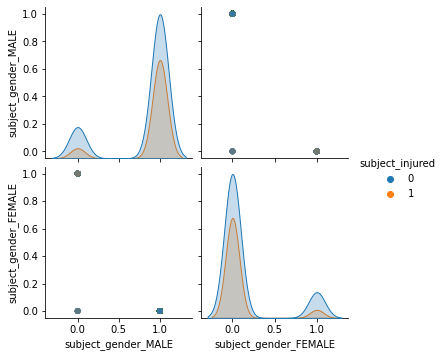

In [157]:
plot_features(df_X[['subject_injured','subject_gender_MALE', 'subject_gender_FEMALE']])

## Eleventh model

In [158]:
X_11 = df_X[['forcetype_Firearm', 'forcetype_Impact Weapon',
                     'forcetype_OC Spray', 'forcetype_Physical Force',
                     'forcetype_Police Canine', 'forcetype_Restraining Mesh Blanket',
                     'force_against_mos_Displayed Weapon',
                     'force_against_mos_Firearm', 'force_against_mos_Impact Weapon',
                     'force_against_mos_Cutting Instrument', 'force_against_mos_Physical Force',
                     'subject_race_ASIAN','subject_race_BLACK', 'subject_race_HISPANIC', 
                     'subject_race_AMER INDIAN','subject_race_WHITE','subject_gender_MALE', 'subject_gender_FEMALE']]

In [159]:
# split data into training/validation and test data

X_tr_val_11, X_te_11, y_tr_val_11, y_te_11 = train_test_split(X_11, y, test_size=0.2, random_state=42)

In [160]:
# logistic regression 

lr_11 = LogisticRegression(solver='lbfgs',max_iter=10000)
lr_11.fit(X_tr_val_11, y_tr_val_11)

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_results = cross_validate(lr_11, X_tr_val_11, y_tr_val_11, cv=kf, scoring='recall')

y_pred_11 = lr_11.predict(X_tr_val_11)

print(f"recall: {(cv_results['test_score'])}")
print("")
print(f"mean recall: {(np.mean(cv_results['test_score'])):.3f}")
print("")
print(f"f2 score: {fbeta_score(y_tr_val_11, y_pred_11, beta=2):.3f}")

recall: [0.38014184 0.42612753 0.37298091 0.37841727 0.36681887]

mean recall: 0.385

f2 score: 0.421


# Create twelfth feature - whether the gender of the subject and all mos is different¶

In [153]:
members['member_gender'].value_counts()

MALE      27817
FEMALE     3440
Name: member_gender, dtype: int64

# Create thirteenth feature -> mos(es)' assignment

In [154]:
#X_4 = np.array(df_X[['subject_used_force_Y','forcetype_Firearm','forcetype_Impact Weapon','forcetype_OC Spray',
                   # 'forcetype_Physical Force','forcetype_Police Canine',
                   # 'forcetype_Restraining Mesh Blanket','num_members_injured']])

In [155]:
# get ratio of features to rows
#(df_X.shape[1]-3)/len(df_X)

In [156]:
# logistic regression with over-sampling

# setup for the ratio argument of RandomOverSampler initialization
#n_pos = np.sum(y_tr_val == 1)
#n_neg = np.sum(y_tr_val == 0)
#ratio = {1 : n_pos * 2, 0 : n_neg} 

# randomly oversample positive samples: create 10x as many 
#ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
    
#X_tr_val_rs, y_tr_val_rs = ROS.fit_resample(X_tr_val, y_tr_val)

#lr_os = LogisticRegression(solver='lbfgs')
#lr_os.fit(X_tr_val_rs, y_tr_val_rs)

#kf = KFold(n_splits=5, shuffle=True, random_state = 71)
#cv_results = cross_validate(lr_os, X_tr_val_rs, y_tr_val_rs, cv=kf, scoring='recall')

#y_pred = lr_os.predict(X_tr_val)

#print(f"recall: {(cv_results['test_score'])}")
#print("")
#print(f"mean recall: {(np.mean(cv_results['test_score'])):.3f}")
#print("")
#print(f"f2 score: {fbeta_score(y_tr_val, y_pred, beta=2):.3f}")

In [157]:
subjects.shape

(13283, 9)

In [159]:
subjects['subject_injured']

0        N
1        N
2        N
3        N
4        N
        ..
13278    Y
13279    Y
13280    Y
13281    Y
13282    Y
Name: subject_injured, Length: 13283, dtype: object

In [160]:
len(subjects.loc[subjects.subject_injured == 'Y'])/len(subjects)

0.323345629752315

In [161]:
members.columns

Index(['mos_id', 'tri_incident_number', 'forcetype', 'injurylevel',
       'member_injured', 'rank_grouped', 'assignment', 'member_gender', 'race',
       'member_injured_rev'],
      dtype='object')

# Logistic Regression models

1. one feature: whether the subject used force (y/n) -> mean recall: 0.0, F2: 0.0
2. two features: whether the subject used force (y/n) and the type of force used by mos -> mean recall: 0.359, F2 score: 0.359 
3. three features: whether the subject used force (y/n), the type of force used by mos, and number of members of service injured (if any) -> mean recall: 0.359, F2 score: 0.390
4. four features: whether the subject used force (y/n), the type of force used by mos, and number of members of service injured (if any), patrol borough -> mean recall: 0.356, F2 score: 0.390
5. four features: the type of force used by mos, type of force used by subject (if any), subject's race, patrol borough -> mean recall: 0.392, F2 score: 0.418
6. five features: the type of force used by mos, type of force used by subject (if any), subject's race, patrol borough, basis for encounter -> mean recall: 0.366, f2 score: 0.410
7. five features: the type of force used by mos, type of force used by subject (if any), subject's race, patrol borough, number of members of service present -> mean recall: 0.389, f2 score: 0.420
8. five features: the type of force used by mos, type of force used by subject (if any), subject's race, number of members of service present, subject's age -> mean recall: .396, f2 score: 0.424
9. five features: the type of force used by mos, type of force used by subject (if any), subject's race, subject's age, mos(es)' race(s) not same as subject's race -> mean recall: .396, f2 score: 0.426
10. three features: the type of force used by mos, type of force used by subject (if any), subject's race -> mean recall: .402, f2 score: .434
11. four features: the type of force used by mos, type of force used by subject (if any), subject's race, subject's gender -> mean recall: .385, f2 score: .421